# Notebook 8: Plant Biology & Agricultural Genomics

**From crop genomes to field phenotypes -- computational approaches to food security**

Prerequisites: Notebooks 1-7 (sequences, genomics, transcriptomics, protein structure, RNAseq, clinical, imaging)

This notebook builds:
1. Plant genome characteristics (polyploidy, TE content, genome size variation)
2. Crop domestication genetics (selective sweeps, bottleneck signatures)
3. GWAS for agricultural traits (yield, drought tolerance, disease resistance)
4. QTL mapping concepts
5. Marker-assisted selection (MAS) simulation
6. Phenotype prediction from genomic data
7. Environmental x Genotype interaction (GxE)
8. Crop diversity and conservation genetics

All data is **synthetically generated** -- no external files or downloads needed.

Libraries: numpy, scipy, sklearn, pandas, matplotlib (core only)

Estimated runtime: ~3 minutes on a laptop (all local computation)

**Key learning outcomes:**
1. Understand how plant genomes differ from animal genomes (polyploidy, TEs)
2. Simulate and detect domestication bottlenecks and selective sweeps
3. Run GWAS on crop breeding lines and interpret Manhattan plots
4. Build genomic prediction models for yield
5. Analyze genotype-by-environment interaction and breeder stability tradeoffs
6. Quantify genetic erosion through breeding cycles

## Section 0: Setup

We use the standard scientific Python stack: **numpy** for simulation,
**scipy** for statistics, **sklearn** for genomic prediction, **pandas** for
data handling, and **matplotlib** for visualization. No specialized plant
biology libraries are required.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
print("Ready -- numpy, scipy, sklearn, pandas, matplotlib")

Ready -- numpy, scipy, sklearn, pandas, matplotlib


## Section 1: Plant Genome Characteristics

Plant genomes are dramatically different from animal genomes:

- **Polyploidy**: Many crops are polyploid (wheat = hexaploid 6x, potato = tetraploid 4x)
- **Genome size**: Ranges from 63 Mb (Genlisea) to 150 Gb (Paris japonica) -- 2400x variation!
- **Transposable elements**: Often >80% of genome (maize ~85%)
- **Gene duplication**: Whole-genome duplications (WGD) are common

Reference [[Degeneracy in Biological Systems]] -- polyploidy creates massive functional
redundancy. Multiple copies of every gene means the system can tolerate mutations,
explore new functions, and buffer against perturbation.

$$\text{Wheat genome: } 3 \text{ subgenomes} \times 7 \text{ chromosomes} \times 2 \text{ (diploid)} = 42 \text{ chromosomes}$$

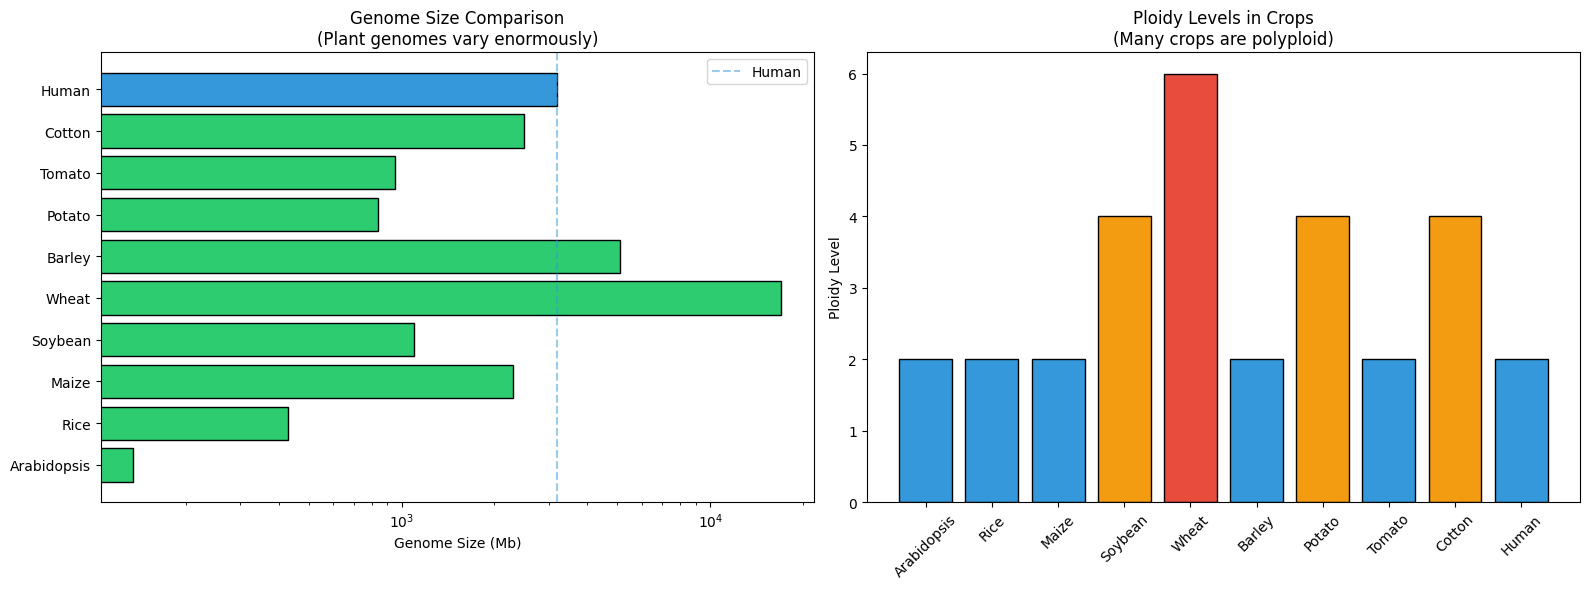

Wheat genome is 5x larger than human -- mostly transposable elements
Wheat is hexaploid (AABBDD) -- three ancestral genomes merged


In [2]:
# Genome sizes of major crops and model organisms (Mb)
genomes = {
    'Arabidopsis': 135,
    'Rice': 430,
    'Maize': 2300,
    'Soybean': 1100,
    'Wheat': 17000,
    'Barley': 5100,
    'Potato': 840,
    'Tomato': 950,
    'Cotton': 2500,
    'Human': 3200,
}

ploidy = {
    'Arabidopsis': 2, 'Rice': 2, 'Maize': 2, 'Soybean': 4,
    'Wheat': 6, 'Barley': 2, 'Potato': 4, 'Tomato': 2,
    'Cotton': 4, 'Human': 2,
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Genome size
names = list(genomes.keys())
sizes = list(genomes.values())
colors_gen = ['#2ecc71' if n != 'Human' else '#3498db' for n in names]
ax1.barh(names, sizes, color=colors_gen, edgecolor='black')
ax1.set_xlabel('Genome Size (Mb)')
ax1.set_title('Genome Size Comparison\n(Plant genomes vary enormously)')
ax1.set_xscale('log')
ax1.axvline(3200, color='#3498db', linestyle='--', alpha=0.5, label='Human')
ax1.legend()

# Ploidy levels
ploidy_colors = {2: '#3498db', 4: '#f39c12', 6: '#e74c3c'}
ax2.bar(names, [ploidy[n] for n in names],
        color=[ploidy_colors[ploidy[n]] for n in names], edgecolor='black')
ax2.set_ylabel('Ploidy Level')
ax2.set_title('Ploidy Levels in Crops\n(Many crops are polyploid)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Wheat genome is 5x larger than human -- mostly transposable elements")
print("Wheat is hexaploid (AABBDD) -- three ancestral genomes merged")

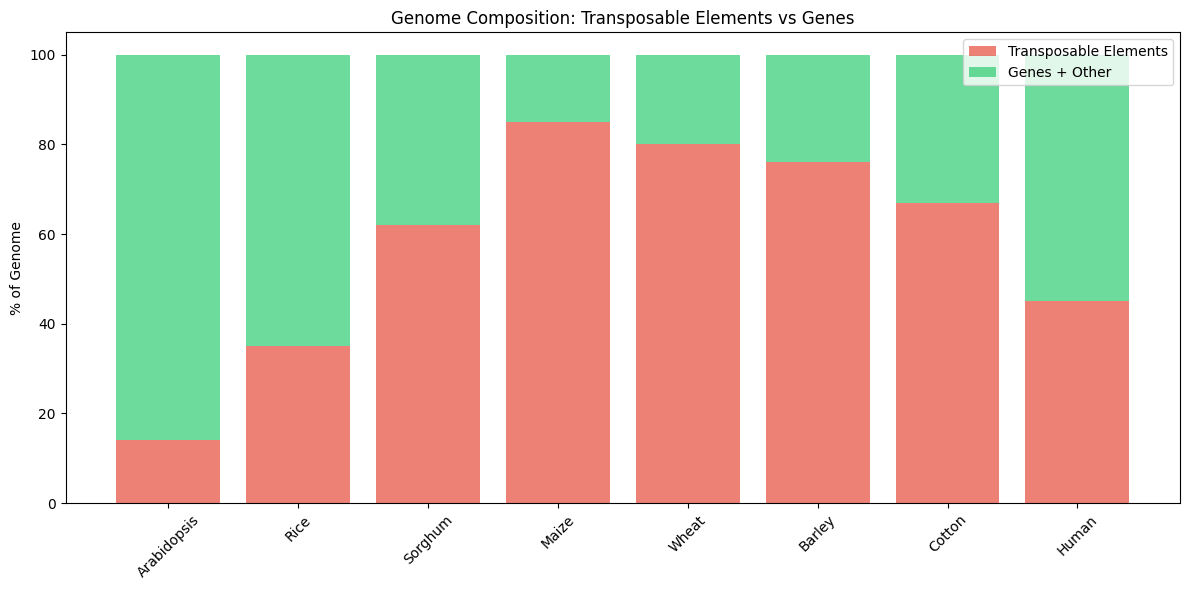

Maize genome: 85% transposable elements, 15% genes/regulatory
This 'junk DNA' is actually a reservoir for evolutionary innovation


In [3]:
# TE content in various plant genomes
te_content = {
    'Arabidopsis': 14, 'Rice': 35, 'Sorghum': 62, 'Maize': 85,
    'Wheat': 80, 'Barley': 76, 'Cotton': 67, 'Human': 45,
}

gene_content = {k: 100 - v for k, v in te_content.items()}

fig, ax = plt.subplots(figsize=(12, 6))
names_te = list(te_content.keys())
te_vals = [te_content[n] for n in names_te]
gene_vals = [gene_content[n] for n in names_te]

ax.bar(names_te, te_vals, color='#e74c3c', alpha=0.7, label='Transposable Elements')
ax.bar(names_te, gene_vals, bottom=te_vals, color='#2ecc71', alpha=0.7, label='Genes + Other')
ax.set_ylabel('% of Genome')
ax.set_title('Genome Composition: Transposable Elements vs Genes')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print("Maize genome: 85% transposable elements, 15% genes/regulatory")
print("This 'junk DNA' is actually a reservoir for evolutionary innovation")

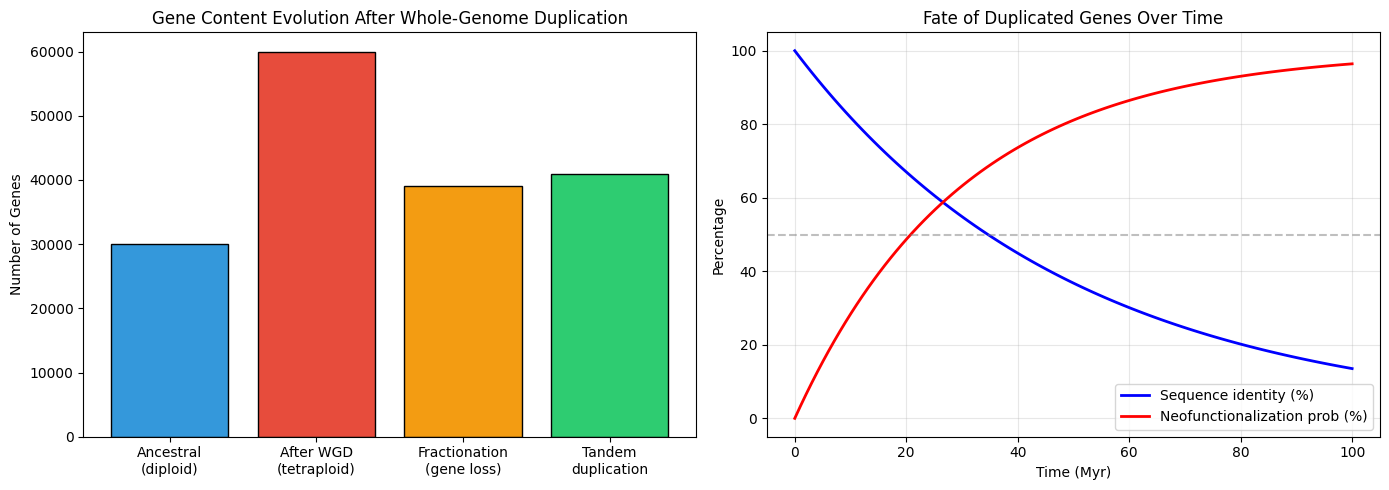

In [4]:
# Simulate gene family expansion through whole-genome duplication
np.random.seed(42)

# Start with 30,000 genes (diploid ancestor)
n_ancestral = 30000

# After WGD: double genes, then lose some (fractionation)
after_wgd = n_ancestral * 2
fractionation_rate = 0.35  # Lose 35% of duplicates
retained = int(after_wgd * (1 - fractionation_rate))

# Some genes get further duplicated (tandem duplication)
tandem_dups = int(retained * 0.05)

generations = ['Ancestral\n(diploid)', 'After WGD\n(tetraploid)', 'Fractionation\n(gene loss)', 'Tandem\nduplication']
gene_counts = [n_ancestral, after_wgd, retained, retained + tandem_dups]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(generations, gene_counts, color=['#3498db', '#e74c3c', '#f39c12', '#2ecc71'], edgecolor='black')
ax1.set_ylabel('Number of Genes')
ax1.set_title('Gene Content Evolution After Whole-Genome Duplication')

# Simulate duplicate divergence over time
time = np.linspace(0, 100, 100)  # Millions of years
identity = 100 * np.exp(-time / 50)  # Exponential divergence
neo = 1 - np.exp(-time / 30)  # Neofunctionalization probability

ax2.plot(time, identity, 'b-', linewidth=2, label='Sequence identity (%)')
ax2.plot(time, neo * 100, 'r-', linewidth=2, label='Neofunctionalization prob (%)')
ax2.axhline(50, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time (Myr)')
ax2.set_ylabel('Percentage')
ax2.set_title('Fate of Duplicated Genes Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 2: Crop Domestication Genetics

Domestication transformed wild plants into crops through intense artificial selection.
Genetic signatures include:

- **Selective sweeps**: Reduced diversity near selected genes
- **Bottleneck**: Loss of diversity during domestication
- **Linkage drag**: Unwanted genes hitchhiking with selected alleles

Key domestication genes:
- **tb1** (maize): branching architecture (teosinte -> maize)
- **Sh1** (rice): shattering (seeds stay on plant)
- **Q** (wheat): free-threshing grain

Reference [[Fitness Landscapes]] -- domestication navigates the fitness landscape
under human-defined objectives rather than natural selection. The "fitness" function
shifts from survival to yield, taste, harvestability.

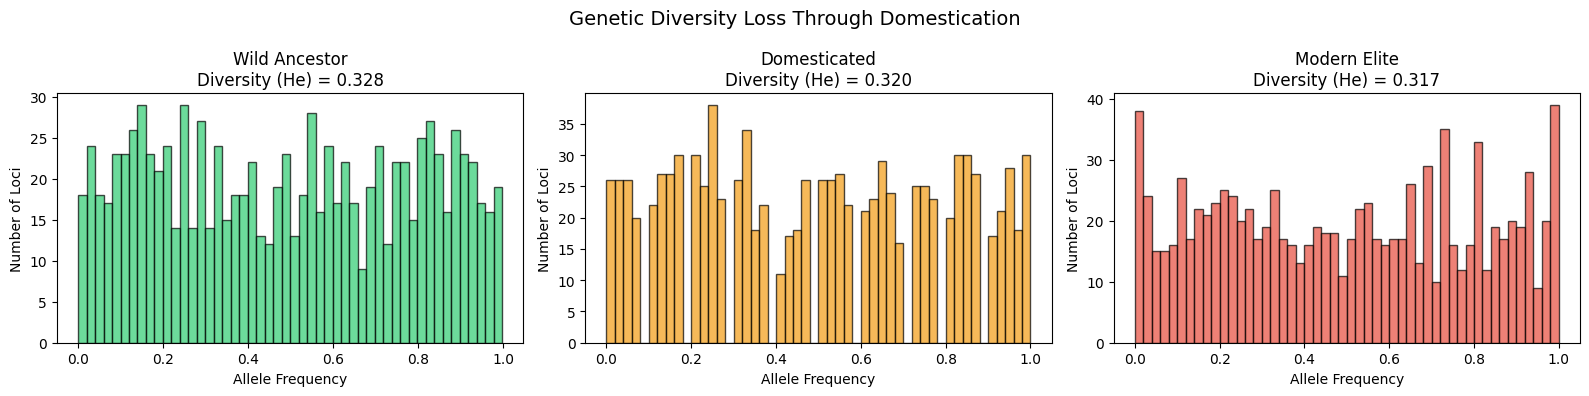

Wild diversity (He): 0.328
Domesticated diversity: 0.320
Modern elite diversity: 0.317
Diversity lost: 3%


In [5]:
np.random.seed(42)
n_snps = 1000

# Wild population (large, diverse)
wild_af = np.random.beta(1, 1, n_snps)  # Uniform(0,1) allele frequencies

# Domestication bottleneck: sample small population
bottleneck_size = 20  # Only ~20 plants domesticated
domesticated_af = []
for af in wild_af:
    # Binomial sampling from small population
    alleles = np.random.binomial(2 * bottleneck_size, af)
    new_af = alleles / (2 * bottleneck_size)
    domesticated_af.append(new_af)
domesticated_af = np.array(domesticated_af)

# Modern breeding (another bottleneck)
elite_size = 50
modern_af = []
for af in domesticated_af:
    alleles = np.random.binomial(2 * elite_size, max(min(af, 0.999), 0.001))
    modern_af.append(alleles / (2 * elite_size))
modern_af = np.array(modern_af)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, af, color) in zip(axes, [
    ('Wild Ancestor', wild_af, '#2ecc71'),
    ('Domesticated', domesticated_af, '#f39c12'),
    ('Modern Elite', modern_af, '#e74c3c'),
]):
    ax.hist(af, bins=50, color=color, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Allele Frequency')
    ax.set_ylabel('Number of Loci')
    ax.set_title(f'{name}\nDiversity (He) = {2*np.mean(af*(1-af)):.3f}')

plt.suptitle('Genetic Diversity Loss Through Domestication', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Wild diversity (He): {2*np.mean(wild_af*(1-wild_af)):.3f}")
print(f"Domesticated diversity: {2*np.mean(domesticated_af*(1-domesticated_af)):.3f}")
print(f"Modern elite diversity: {2*np.mean(modern_af*(1-modern_af)):.3f}")
print(f"Diversity lost: {(1 - 2*np.mean(modern_af*(1-modern_af))/(2*np.mean(wild_af*(1-wild_af))))*100:.0f}%")

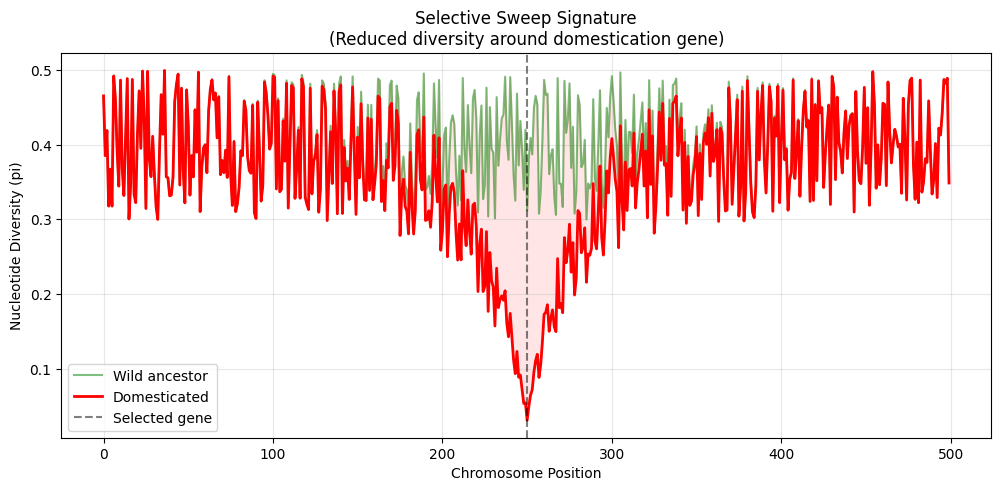

The 'valley' of reduced diversity = selective sweep footprint
Width of valley depends on recombination rate and selection strength


In [6]:
# Simulate a selective sweep around a domestication gene
n_pos = 500  # Positions along chromosome
position = np.arange(n_pos)
target = 250  # Position of selected gene

# Diversity across chromosome (normally high)
diversity_wild = np.random.uniform(0.3, 0.5, n_pos)

# Sweep reduces diversity near target (stronger effect closer to gene)
diversity_dom = diversity_wild.copy()
for i in range(n_pos):
    dist = abs(i - target)
    reduction = np.exp(-dist / 30)  # Exponential decay
    diversity_dom[i] *= (1 - 0.9 * reduction)

plt.figure(figsize=(12, 5))
plt.plot(position, diversity_wild, 'g-', alpha=0.5, label='Wild ancestor')
plt.plot(position, diversity_dom, 'r-', linewidth=2, label='Domesticated')
plt.axvline(target, color='black', linestyle='--', alpha=0.5, label='Selected gene')
plt.fill_between(position, diversity_dom, diversity_wild, alpha=0.1, color='red')
plt.xlabel('Chromosome Position')
plt.ylabel('Nucleotide Diversity (pi)')
plt.title('Selective Sweep Signature\n(Reduced diversity around domestication gene)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("The 'valley' of reduced diversity = selective sweep footprint")
print("Width of valley depends on recombination rate and selection strength")

## Section 3: Agricultural GWAS

GWAS in crops identifies genomic regions associated with agronomic traits:
yield, drought tolerance, disease resistance, grain quality. Unlike human GWAS,
plant GWAS can leverage:

- Controlled crosses (recombinant inbred lines)
- Replicated field trials
- Known pedigrees

Reference [[Variant-Phenotype Mapping]] and [[Genotype-to-Phenotype Hub]] --
the fundamental challenge of mapping genotype to phenotype is the same across
species, but plant systems offer experimental advantages that humans lack.

In [7]:
np.random.seed(42)
n_lines = 300  # Crop breeding lines
n_markers = 3000  # SNP markers

# Genotypes
mafs_crop = np.random.beta(1, 3, n_markers)
mafs_crop = np.clip(mafs_crop, 0.05, 0.45)

geno_crop = np.zeros((n_lines, n_markers), dtype=int)
for j in range(n_markers):
    p = mafs_crop[j]
    geno_crop[:, j] = np.random.choice([0, 1, 2], size=n_lines,
                                        p=[(1-p)**2, 2*p*(1-p), p**2])

# 10 QTLs affecting yield (some large, some small effect)
n_qtl = 10
qtl_indices = np.random.choice(n_markers, n_qtl, replace=False)
qtl_effects = np.concatenate([
    np.random.normal(0.8, 0.2, 3),   # 3 major QTLs
    np.random.normal(0.3, 0.1, 7),   # 7 minor QTLs
])

# Phenotype: yield (tons/hectare)
yield_genetic = np.zeros(n_lines)
for idx, effect in zip(qtl_indices, qtl_effects):
    yield_genetic += effect * geno_crop[:, idx]

# Environmental noise (field variation)
yield_env = np.random.normal(0, 1.5, n_lines)
yield_total = 5.0 + yield_genetic + yield_env  # Base yield + genetics + environment
yield_total = np.clip(yield_total, 1, 12)

# Heritability
h2 = np.var(yield_genetic) / np.var(yield_total)

print(f"Crop GWAS simulation: {n_lines} lines, {n_markers} markers")
print(f"QTLs: {n_qtl} (3 major + 7 minor)")
print(f"Heritability (h2): {h2:.2f}")
print(f"Yield range: {yield_total.min():.1f} - {yield_total.max():.1f} t/ha")

Crop GWAS simulation: 300 lines, 3000 markers
QTLs: 10 (3 major + 7 minor)
Heritability (h2): 0.26
Yield range: 1.0 - 11.1 t/ha


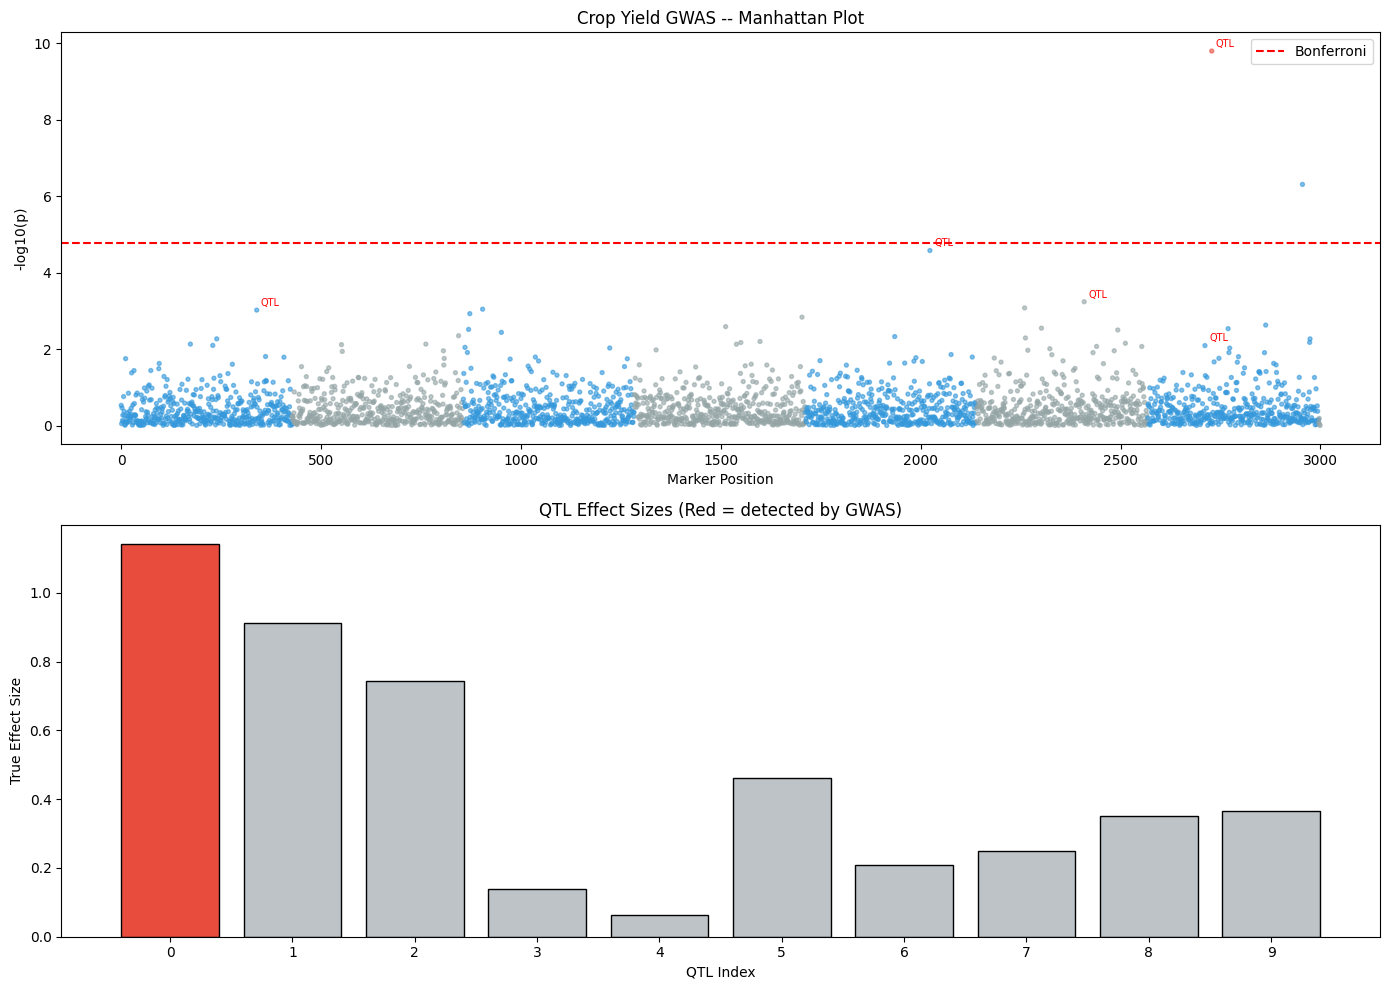

QTLs detected: 1 / 10
Large-effect QTLs are easily detected; small-effect QTLs need larger populations


In [8]:
# Association test for each marker
pvalues_crop = np.zeros(n_markers)
effects_crop = np.zeros(n_markers)

for j in range(n_markers):
    slope, intercept, r, p, se = stats.linregress(geno_crop[:, j].astype(float), yield_total)
    pvalues_crop[j] = p
    effects_crop[j] = slope

bonferroni_crop = 0.05 / n_markers

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Manhattan plot with chromosome coloring
neg_log_p = -np.log10(pvalues_crop)
chrom_size = n_markers // 7  # Simulate 7 chromosomes
chrom_colors = []
for i in range(n_markers):
    chrom = i // chrom_size
    chrom_colors.append('#3498db' if chrom % 2 == 0 else '#95a5a6')
    if i in qtl_indices and pvalues_crop[i] < bonferroni_crop:
        chrom_colors[-1] = '#e74c3c'

ax1.scatter(range(n_markers), neg_log_p, c=chrom_colors, s=8, alpha=0.6)
ax1.axhline(-np.log10(bonferroni_crop), color='red', linestyle='--', label='Bonferroni')
ax1.set_xlabel('Marker Position')
ax1.set_ylabel('-log10(p)')
ax1.set_title('Crop Yield GWAS -- Manhattan Plot')
ax1.legend()

# Mark QTL positions
for idx in qtl_indices:
    if neg_log_p[idx] > 2:
        ax1.annotate('QTL', (idx, neg_log_p[idx]), fontsize=7, color='red',
                    xytext=(3, 3), textcoords='offset points')

# QTL effect sizes
detected = pvalues_crop[qtl_indices] < bonferroni_crop
ax2.bar(range(n_qtl), qtl_effects,
        color=['#e74c3c' if d else '#bdc3c7' for d in detected], edgecolor='black')
ax2.set_xlabel('QTL Index')
ax2.set_ylabel('True Effect Size')
ax2.set_title('QTL Effect Sizes (Red = detected by GWAS)')
ax2.set_xticks(range(n_qtl))

plt.tight_layout()
plt.show()

n_detected = (pvalues_crop[qtl_indices] < bonferroni_crop).sum()
print(f"QTLs detected: {n_detected} / {n_qtl}")
print("Large-effect QTLs are easily detected; small-effect QTLs need larger populations")

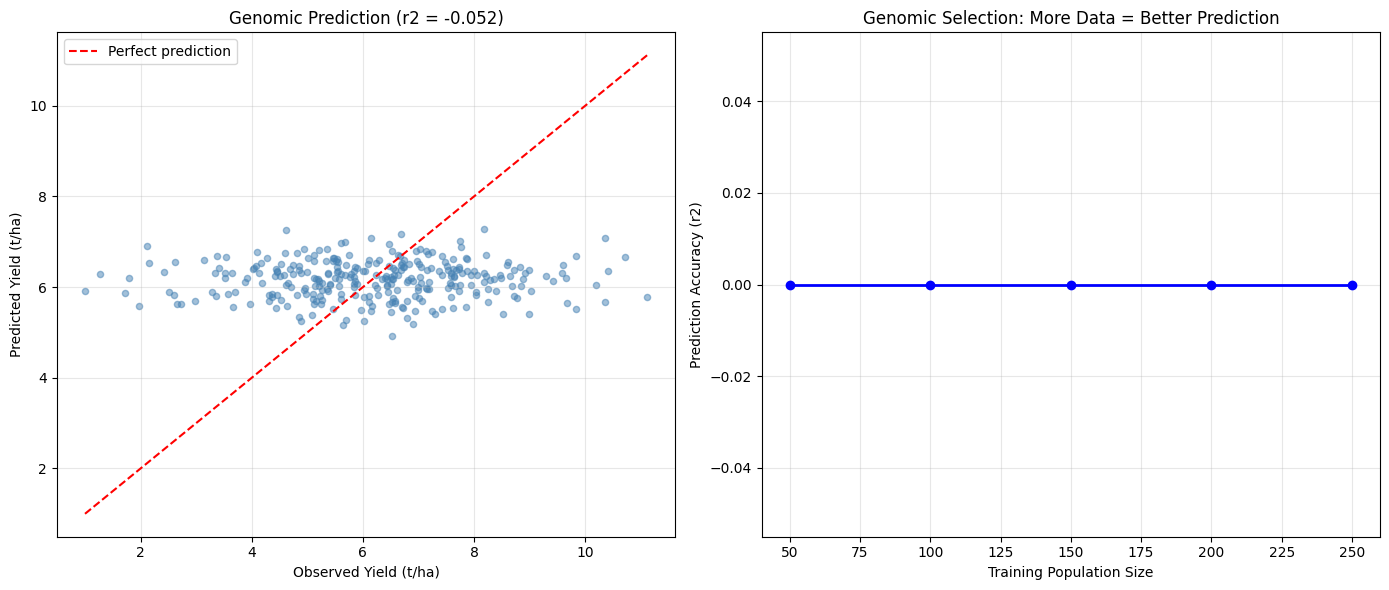

Best ridge alpha: 1000
Cross-validated r2: -0.052
Prediction accuracy: 0.034 (correlation)


In [9]:
# Genomic prediction: predict yield from all markers simultaneously
# This is the modern approach (vs single-marker GWAS)

# Ridge regression as a simplified GBLUP
from sklearn.model_selection import cross_val_predict

# Standardize genotypes
X = geno_crop.astype(float)
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-10)
y = yield_total

# Cross-validated prediction
alphas = [0.1, 1, 10, 100, 1000]
best_r2 = -np.inf
best_alpha = None

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X, y, cv=5, scoring='r2')
    mean_r2 = scores.mean()
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_alpha = alpha

# Final prediction
ridge = Ridge(alpha=best_alpha)
y_pred = cross_val_predict(ridge, X, y, cv=5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y, y_pred, alpha=0.5, s=20, color='steelblue')
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect prediction')
ax1.set_xlabel('Observed Yield (t/ha)')
ax1.set_ylabel('Predicted Yield (t/ha)')
ax1.set_title(f'Genomic Prediction (r2 = {best_r2:.3f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Prediction accuracy vs training size
train_sizes = [50, 100, 150, 200, 250]
r2_by_size = []
for n_train in train_sizes:
    ridge_sub = Ridge(alpha=best_alpha)
    scores_sub = cross_val_score(ridge_sub, X[:n_train], y[:n_train],
                                  cv=min(5, n_train // 10), scoring='r2')
    r2_by_size.append(max(scores_sub.mean(), 0))

ax2.plot(train_sizes, r2_by_size, 'bo-', linewidth=2)
ax2.set_xlabel('Training Population Size')
ax2.set_ylabel('Prediction Accuracy (r2)')
ax2.set_title('Genomic Selection: More Data = Better Prediction')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best ridge alpha: {best_alpha}")
print(f"Cross-validated r2: {best_r2:.3f}")
print(f"Prediction accuracy: {np.corrcoef(y, y_pred)[0,1]:.3f} (correlation)")

## Section 4: Genotype x Environment Interaction (GxE)

Genotype x Environment (GxE) interaction means a variety's performance depends
on where it is grown. A drought-tolerant line may excel in dry environments but
underperform in irrigated conditions.

Reference [[Context Conditionality]] -- f(genotype, environment) -> phenotype.
The same genome produces different outcomes in different contexts. This is the
agricultural expression of context-conditionality.

$$Y_{ijk} = \mu + G_i + E_j + (GE)_{ij} + \epsilon_{ijk}$$

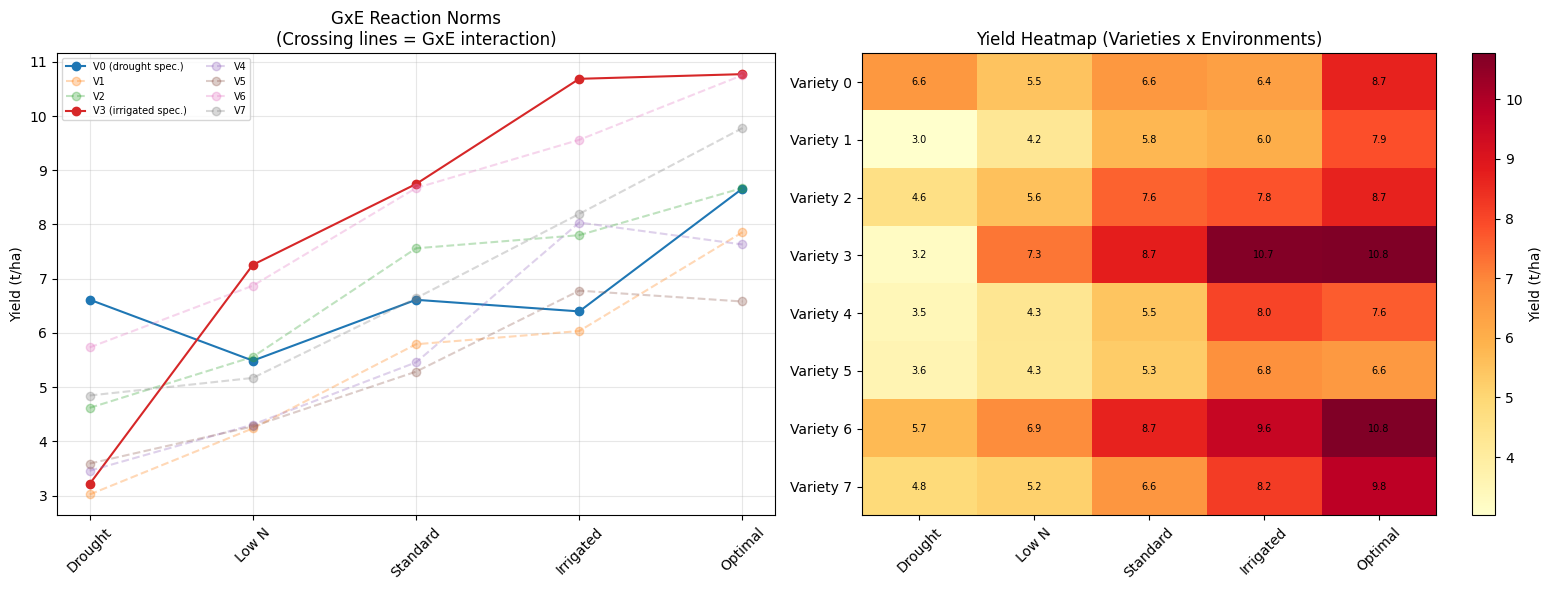

In [10]:
np.random.seed(42)
n_varieties = 8
n_environments = 5

# Variety means (genetic value)
variety_means = np.random.normal(6, 1.5, n_varieties)

# Environment means
env_means = np.array([-2, -1, 0, 1, 2])  # Poor to ideal conditions
env_names = ['Drought', 'Low N', 'Standard', 'Irrigated', 'Optimal']

# GxE interaction (some varieties are specialists, some generalists)
ge_interaction = np.random.normal(0, 0.5, (n_varieties, n_environments))
# Make variety 0 a drought specialist
ge_interaction[0, 0] += 2  # Great in drought
ge_interaction[0, 3] -= 1  # Poor when irrigated
# Make variety 3 a high-input specialist
ge_interaction[3, 3] += 2  # Great irrigated
ge_interaction[3, 0] -= 2  # Terrible in drought

yields_ge = np.zeros((n_varieties, n_environments))
for i in range(n_varieties):
    for j in range(n_environments):
        yields_ge[i, j] = (variety_means[i] + env_means[j] +
                           ge_interaction[i, j] + np.random.normal(0, 0.3))
yields_ge = np.clip(yields_ge, 0, 12)

# GGE biplot-style visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Reaction norms
for i in range(n_varieties):
    style = '-' if i in [0, 3] else '--'
    alpha_val = 1.0 if i in [0, 3] else 0.3
    label = (f'V{i} (drought spec.)' if i == 0 else
             f'V{i} (irrigated spec.)' if i == 3 else f'V{i}')
    ax1.plot(range(n_environments), yields_ge[i], style,
             alpha=alpha_val, marker='o', label=label)

ax1.set_xticks(range(n_environments))
ax1.set_xticklabels(env_names, rotation=45)
ax1.set_ylabel('Yield (t/ha)')
ax1.set_title('GxE Reaction Norms\n(Crossing lines = GxE interaction)')
ax1.legend(fontsize=7, ncol=2)
ax1.grid(True, alpha=0.3)

# Heatmap
im = ax2.imshow(yields_ge, cmap='YlOrRd', aspect='auto')
ax2.set_xticks(range(n_environments))
ax2.set_xticklabels(env_names, rotation=45)
ax2.set_yticks(range(n_varieties))
ax2.set_yticklabels([f'Variety {i}' for i in range(n_varieties)])
ax2.set_title('Yield Heatmap (Varieties x Environments)')
plt.colorbar(im, ax=ax2, label='Yield (t/ha)')

for i in range(n_varieties):
    for j in range(n_environments):
        ax2.text(j, i, f'{yields_ge[i,j]:.1f}', ha='center', va='center', fontsize=7)

plt.tight_layout()
plt.show()

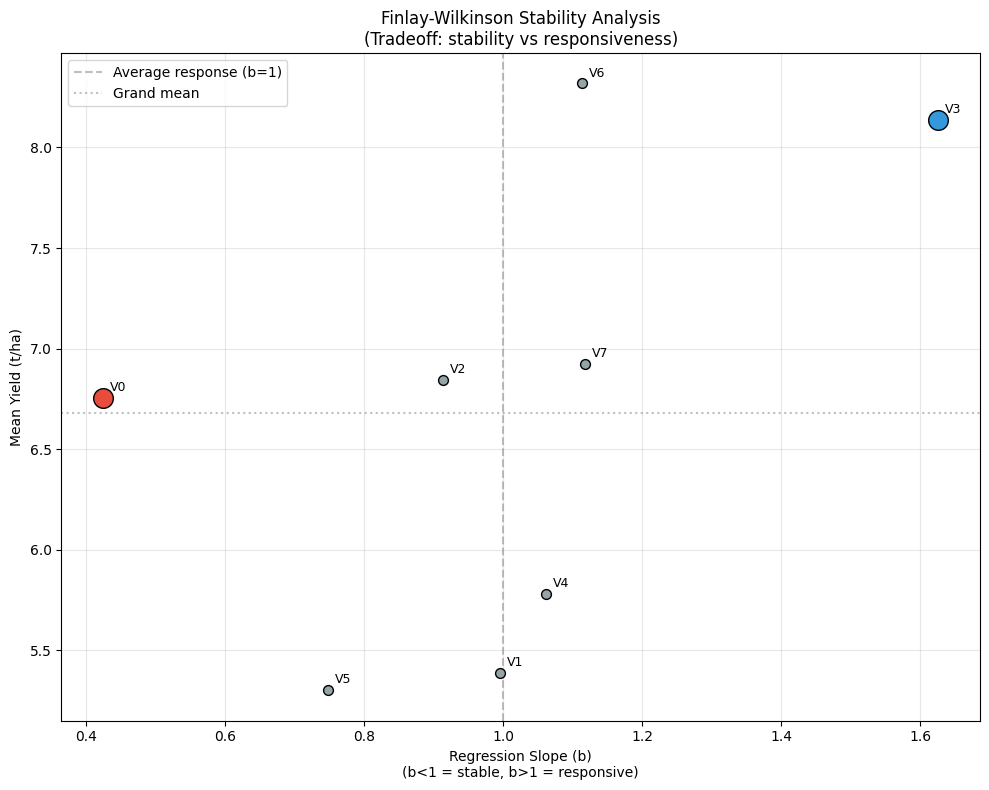

Drought specialist (V0): low slope = stable across environments
Irrigated specialist (V3): high slope = responsive to good conditions
Breeders must choose: stable performers vs high-ceiling varieties


In [11]:
# Finlay-Wilkinson stability analysis
env_index = yields_ge.mean(axis=0)  # Environment mean

slopes = []
intercepts = []
for i in range(n_varieties):
    slope, intercept, _, _, _ = stats.linregress(env_index, yields_ge[i])
    slopes.append(slope)
    intercepts.append(intercept)

fig, ax = plt.subplots(figsize=(10, 8))

for i in range(n_varieties):
    color = '#e74c3c' if i == 0 else '#3498db' if i == 3 else '#95a5a6'
    size = 200 if i in [0, 3] else 50
    ax.scatter(slopes[i], np.mean(yields_ge[i]), s=size, c=color,
               edgecolors='black', zorder=5)
    ax.annotate(f'V{i}', (slopes[i], np.mean(yields_ge[i])), fontsize=9,
               xytext=(5, 5), textcoords='offset points')

ax.axvline(1.0, color='gray', linestyle='--', alpha=0.5, label='Average response (b=1)')
ax.axhline(np.mean(yields_ge), color='gray', linestyle=':', alpha=0.5, label='Grand mean')
ax.set_xlabel('Regression Slope (b)\n(b<1 = stable, b>1 = responsive)')
ax.set_ylabel('Mean Yield (t/ha)')
ax.set_title('Finlay-Wilkinson Stability Analysis\n(Tradeoff: stability vs responsiveness)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Drought specialist (V0): low slope = stable across environments")
print("Irrigated specialist (V3): high slope = responsive to good conditions")
print("Breeders must choose: stable performers vs high-ceiling varieties")

## Section 5: Crop Diversity and Conservation Genetics

Modern breeding progressively narrows the genetic base of crops. Each cycle of
selection fixes alleles and removes variation. This "genetic erosion" makes crops
vulnerable to new diseases and climate shifts.

Conservation genetics preserves diversity through gene banks, in-situ conservation
of wild relatives, and strategic germplasm introduction into breeding programs.

Reference [[Robustness and Evolvability]] -- genetic diversity is the raw material
for future adaptation. Reducing it trades short-term gain for long-term fragility.

Reference [[Evolutionary Tinkering]] -- evolution does not design from scratch;
it tinkers with existing variation. No variation = no tinkering = no adaptation.

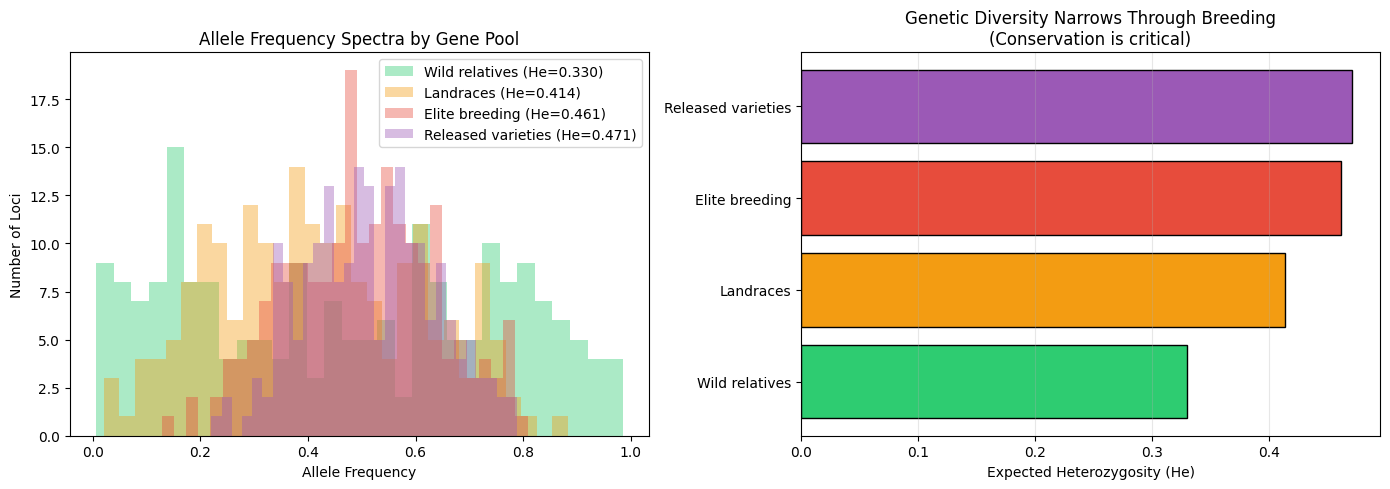

In [12]:
np.random.seed(42)
# Simulate genetic diversity across crop gene pools
collections = {
    'Wild relatives': np.random.beta(1, 1, 200),
    'Landraces': np.random.beta(2, 3, 200),
    'Elite breeding': np.random.beta(5, 5, 200),
    'Released varieties': np.random.beta(8, 8, 200),
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors_coll = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
for (name, af), color in zip(collections.items(), colors_coll):
    he = 2 * np.mean(af * (1 - af))
    ax1.hist(af, bins=30, alpha=0.4, label=f'{name} (He={he:.3f})', color=color)

ax1.set_xlabel('Allele Frequency')
ax1.set_ylabel('Number of Loci')
ax1.set_title('Allele Frequency Spectra by Gene Pool')
ax1.legend()

# Diversity pyramid
pools = list(collections.keys())
diversities = [2 * np.mean(af * (1 - af)) for af in collections.values()]
ax2.barh(pools, diversities, color=colors_coll, edgecolor='black')
ax2.set_xlabel('Expected Heterozygosity (He)')
ax2.set_title('Genetic Diversity Narrows Through Breeding\n(Conservation is critical)')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

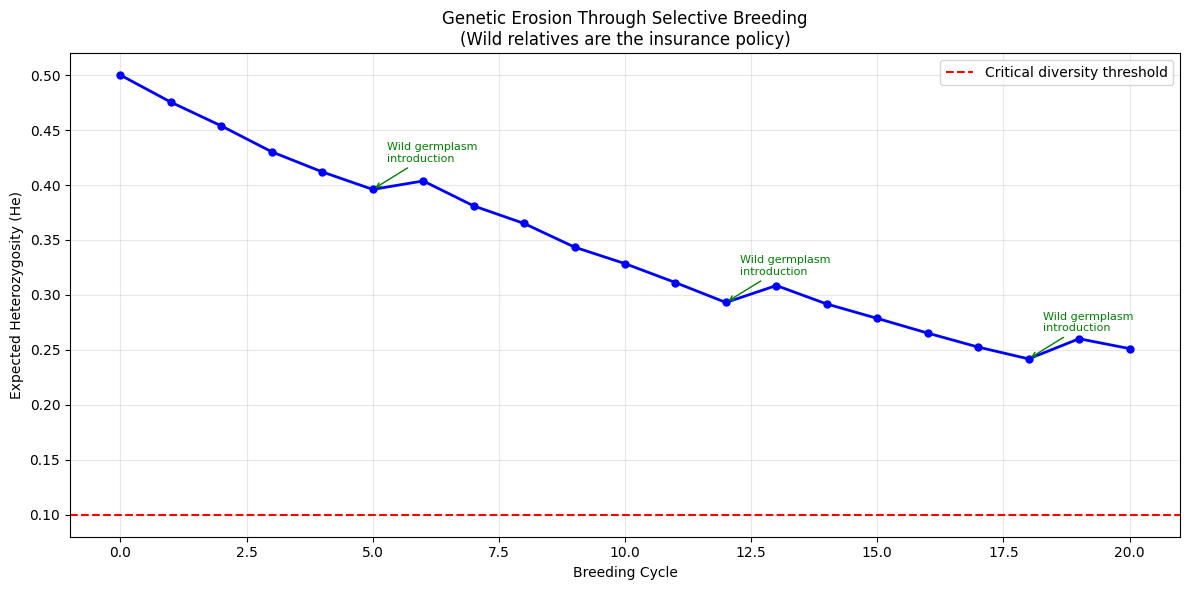

Key insight: Modern breeding narrows the genetic base
Gene banks preserving wild relatives are critical for future adaptation
Climate change requires traits (drought, heat tolerance) found in wild germplasm


In [13]:
# Simulate diversity loss over breeding cycles
n_cycles = 20
diversity_timeline = [0.5]  # Starting He

for cycle in range(n_cycles):
    # Each cycle: selection reduces diversity
    current = diversity_timeline[-1]
    # Selection intensity reduces He by ~5% per cycle
    new_he = current * (1 - 0.05 - np.random.normal(0, 0.01))
    # Occasional introduction of wild germplasm restores some diversity
    if cycle in [5, 12, 18]:  # Germplasm introduction events
        new_he += 0.03
    diversity_timeline.append(max(new_he, 0.05))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(n_cycles + 1), diversity_timeline, 'b-o', linewidth=2, markersize=5)
ax.axhline(0.1, color='red', linestyle='--', label='Critical diversity threshold')

# Mark introduction events
for cycle in [5, 12, 18]:
    ax.annotate('Wild germplasm\nintroduction', (cycle, diversity_timeline[cycle]),
               fontsize=8, color='green',
               xytext=(10, 20), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', color='green'))

ax.set_xlabel('Breeding Cycle')
ax.set_ylabel('Expected Heterozygosity (He)')
ax.set_title('Genetic Erosion Through Selective Breeding\n(Wild relatives are the insurance policy)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key insight: Modern breeding narrows the genetic base")
print("Gene banks preserving wild relatives are critical for future adaptation")
print("Climate change requires traits (drought, heat tolerance) found in wild germplasm")

## Summary

| Concept | What you built | Why it matters |
|---------|---------------|----------------|
| Polyploidy | Genome size comparison | Plants break diploid rules |
| TE content | Genome composition | Most plant DNA is mobile elements |
| Gene duplication | WGD + fractionation model | [[Degeneracy in Biological Systems]] |
| Domestication | Bottleneck + sweep simulation | How wild plants became crops |
| Crop GWAS | Yield association mapping | Find genes for breeding |
| Genomic prediction | Ridge regression on markers | Modern breeding tool (GS) |
| GxE interaction | Reaction norms + stability | [[Context Conditionality]] in agriculture |
| Conservation | Diversity erosion | Wild relatives = future food security |

**Connections to conceptual framework:**
- [[Degeneracy in Biological Systems]]: Polyploidy creates redundancy for evolutionary exploration
- [[Fitness Landscapes]]: Domestication navigates landscapes under human objectives
- [[Variant-Phenotype Mapping]]: Crop GWAS maps genotype to yield
- [[Genotype-to-Phenotype Hub]]: The central challenge across all species
- [[Context Conditionality]]: GxE interaction -- same genome, different environments, different yields
- [[Robustness and Evolvability]]: Genetic diversity enables future adaptation
- [[Evolutionary Tinkering]]: Evolution works with existing variation
- [[Plant-Animal Divergence]]: Why plant genomes are so different

**The complete series:**
- [[01_Sequence_Analysis_Fundamentals]] -- Biopython, the Central Dogma
- [[02_Genomic_Variant_Analysis]] -- Population genetics, GWAS
- [[03_Single_Cell_Transcriptomics]] -- scanpy, cell type discovery
- [[04_Protein_Structure_Drug_Discovery]] -- Structure and drug design
- [[05_Bulk_RNAseq_Differential_Expression]] -- Differential expression analysis
- [[06_Clinical_Biomedical_Informatics]] -- Clinical data and survival analysis
- [[07_Biomedical_Image_Analysis]] -- Pathology and radiology
- [[08_Plant_Biology_Agricultural_Genomics]] -- Crops and food security (this notebook)